# Forex Arbitrage

This notebook presents an example of linear optimization on a network model for financial transactions. The goal is to identify whether or not an arbitrage opportunity exists given a matrix of cross-currency exchange rates. Other treatments of this problem and application are available, including the following links.

* [Crypto Arbitrage Framework](https://github.com/hzjken/crypto-arbitrage-framework)
* [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)


In [6]:
# install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Problem

Exchanging one currency for another is among the most common of all banking transactions. Currencies are normally priced relative to each other. 

At this moment of this writing, for example, the Japanese yen (symbol JPY) is priced at 0.00761 relative to the euro (symbol EUR). At this price 100 euros would purchase 100/0.00761 = 13,140.6 yen. Conversely, EUR is priced at 131.585 yen.  The 'round-trip' of 100 euros from EUR to JPY and back to EUR results in

$$100 \text{ EUR} \times \frac{1\text{ JPY}}{0.00761\text{ EUR}} {\quad\longrightarrow\quad} 12,140.6 \text{ JPY} \times\frac{1\text{ EUR}}{131.585\text{ JPY}} {\quad\longrightarrow\quad} 99.9954\text{ EUR}$$

The small loss in this round-trip transaction is the fee collected by the brokers and banking system to provide these services. 

Needless to say, if a simple round-trip transaction like this reliably produced a net gain then there would many eager traders ready to take advantage of the situation. Trading situations offering a net gain with no risk are called arbitrage, and are the subject of intense interest by traders in the foreign exchange (forex) and crypto-currency markets around the globe.

As one might expect, arbitrage opportunities involving a simple round-trip between a pair of currencies are almost non-existent in real-world markets. When the do appear, they are easily detected and rapid and automated trading  quickly exploit the situation. More complex arbitrage opportunities, however, can arise when working with three more currencies and a table of cross-currency exchange rates.



## Demonstration of Triangular Arbitrage

Consider the following cross-currency matrix. 

| i <- J | USD | EUR | JPY |
| :--- | :---: | :---: | :---: |
| USD | 1.0 | 2.0 | 0.01 |
| EUR | 0.5 | 1.0 | 0.0075 |
| JPY | 100.0 | 133 1/3 | 1.0 |


Entry $a_{m, n}$ is the number units of currency $m$ received in exchange for one unit of currency $n$.  We use the notation 

$$a_{m, n} = a_{m \leftarrow n}$$

as reminder of what the entries denote. For this given data there are no two way arbitrage opportunities. We check this by explicitly computing all two-way currency exchanges

$$I \rightarrow J \rightarrow I$$

by computing

$$ a_{i \leftarrow j} \times a_{j \leftarrow i}$$

This particular example shows no net cost and no arbitrage for conversion from one currency to another and back again.

In [7]:
import pandas as pd

df = pd.DataFrame([[1.0, 0.5, 100], [2.0, 1.0, 1/0.0075], [0.01, 0.0075, 1.0]],
                  columns = ['USD', 'EUR', 'JPY'],
                  index = ['USD', 'EUR', 'JPY']).T

display(df)

# USD -> EUR -> USD
print(df.loc['USD', 'EUR'] * df.loc['EUR', 'USD'])

# USD -> JPY -> USD
print(df.loc['USD', 'JPY'] * df.loc['JPY', 'USD'])

# EUR -> JPY -> EUR
print(df.loc['EUR', 'JPY'] * df.loc['JPY', 'EUR'])


,USD,EUR,JPY
USD,1.0,2.000000,0.0100
EUR,0.5,1.000000,0.0075
JPY,100.0,133.333333,1.0000


1.0
1.0
1.0


Now consider a three-way exchange

$$ I \rightarrow J \rightarrow K \rightarrow I $$

The exchange rate can be computed as

$$ a_{i \leftarrow k} \times a_{k \leftarrow j} \times a_{j \leftarrow i} $$

By direct calculation we see there is a three-way **triangular** arbitrage opportunity.

In [8]:
I = 'USD'
J = 'JPY'
K = 'EUR'

print(df.loc[I, K] * df.loc[K, J] * df.loc[J, I])

1.5


Our challenge is create a model that can identify complex arbitrage opportunities that may exist in cross-currency forex markets.

## Modeling

The cross-currency table $A$ provides exchange rates among currencies. Entry $a_{i,j}$ in row $i$, column $j$ tells us how many units of currency $i$ are received in exchange for one unit of currency $j$. We'll use the notation $a_{i, j} = a_{i\leftarrow j}$ to remind ourselves of this relationship.

We start with $w_j(0)$ units of currency $j \in N$. In the first phase of a transaction, an amount $x_{i\leftarrow j}(t)$  is committed for exchange to currency $i$. After the commitment the unencumbered balance is

$$w_j(t-1) - \sum_{i\ne j} x_{i\leftarrow j}(t) \geq 0$$

This constraint prohibits shorting one currency to buy another. The transaction is completed when the exchange credits accounts in the new currencies

$$ w_j(t) = w_j(t-1) - \underbrace{\sum_{i\ne j} x_{i\leftarrow j}(t)}_{\text{outgoing}} + \underbrace{\sum_{i\ne j} a_{j\leftarrow i}x_{j\leftarrow i}(t)}_{\text{incoming}} $$

The goal of this calculation is to find a set of transactions $x_{i\leftarrow j}(t) \geq 0$ to maximize the value of portfolio at a later time $T$.


In [9]:
import pyomo.environ as pyo
import numpy as np
from graphviz import Digraph

def arbitrage(T, df, R='EUR'):

    m = pyo.ConcreteModel()

    # length of trading chain
    m.T0 = pyo.RangeSet(0, T)

    # number of transactions
    m.T1 = pyo.RangeSet(1, T)

    # currency *nodes*
    m.NODES = pyo.Set(initialize=df.index)

    # paths between currency nodes i -> j
    m.ARCS = pyo.Set(initialize = m.NODES * m.NODES, filter = lambda arb, i, j: i != j)

    # w[i, t] amount of currency i on hand after transaction t
    m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

    # x[m, n, t] amount of currency m converted to currency n in transaction t t
    m.x = pyo.Var(m.ARCS, m.T1, domain=pyo.NonNegativeReals)
    
    # start with assignment of 100 units of a selected reserve currency
    @m.Constraint(m.NODES)
    def initial_condition(m, i):
        if i == R:
            return m.w[i, 0] == 100.0
        return m.w[i, 0] == 0

    # no shorting constraint
    @m.Constraint(m.NODES, m.T1)
    def max_trade(m, j, t):
        return m.w[j, t-1] >= sum(m.x[i, j, t] for i in m.NODES if i != j)

    # one round of transactions
    @m.Constraint(m.NODES, m.T1)
    def balances(m, j, t):
        return m.w[j, t] == m.w[j, t-1] - sum(m.x[i, j, t] for i in m.NODES if i != j) \
                               + sum(df.loc[j, i]*m.x[j, i, t] for i in m.NODES if i != j)

    @m.Objective(sense=pyo.maximize)
    def wealth(m):
        return m.w[R, T]

    solver = pyo.SolverFactory('glpk')
    solver.solve(m)

    for t in m.T0:
        print(f"\nt = {t}\n")
        if t >= 1:
            for i, j in m.ARCS:
                if m.x[i,j,t]() > 0:
                    print(f"{j} -> {i}  Convert {m.x[i, j, t]()} {j} to {df.loc[i,j]*m.x[i,j,t]()} {i}")
            print()
            
        for i in m.NODES:
            print(f"w[{i},{t}] = {m.w[i, t]():9.2f} ")
    
    return m
            

m = arbitrage(3, df, 'EUR')



t = 0

w[USD,0] =      0.00 
w[EUR,0] =    100.00 
w[JPY,0] =      0.00 

t = 1

EUR -> USD  Convert 100.0 EUR to 200.0 USD

w[USD,1] =    200.00 
w[EUR,1] =      0.00 
w[JPY,1] =      0.00 

t = 2

USD -> JPY  Convert 200.0 USD to 20000.0 JPY

w[USD,2] =      0.00 
w[EUR,2] =      0.00 
w[JPY,2] =  20000.00 

t = 3

JPY -> EUR  Convert 20000.0 JPY to 150.0 EUR

w[USD,3] =      0.00 
w[EUR,3] =    150.00 
w[JPY,3] =      0.00 


## Display graph

In [10]:
def graph(m):
    dot = Digraph()
    for i in m.NODES:
        dot.node(i)

    for t in m.T1:
        for i, j in m.ARCS:
            if m.x[i, j, t]() > 0.1:
                y = m.w[j,t-1]()
                x = m.w[i,t]()
                dot.edge(i, j) # label=f"{m.x[i, j, t]():0.1f}")
    return dot

graph(m)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## FOREX data

https://www.bloomberg.com/markets/currencies/cross-rates

https://www.tradingview.com/markets/currencies/cross-rates-overview-prices/

In [ ]:
# data extracted 2022-03-17

bloomberg = """
	USD	EUR	JPY	GBP	CHF	CAD	AUD	HKD
USD	-	1.1096	0.0084	1.3148	1.0677	0.7915	0.7376	0.1279
EUR	0.9012	-	0.0076	1.1849	0.9622	0.7133	0.6647	0.1153
JPY	118.6100	131.6097	-	155.9484	126.6389	93.8816	87.4867	15.1724
GBP	0.7606	0.8439	0.0064	-	0.8121	0.6020	0.5610	0.0973
CHF	0.9366	1.0393	0.0079	1.2314	-	0.7413	0.6908	0.1198
CAD	1.2634	1.4019	0.0107	1.6611	1.3489	-	0.9319	0.1616
AUD	1.3557	1.5043	0.0114	1.7825	1.4475	1.0731	-	0.1734
HKD	7.8175	8.6743	0.0659	10.2784	8.3467	6.1877	5.7662	-
"""

import pandas as pd
import io

df = pd.read_csv(io.StringIO(bloomberg.replace('-', '1.0')), sep='\t', index_col=0)
display(df)

,USD,EUR,JPY,GBP,CHF,CAD,AUD,HKD
USD,1.0000,1.1096,0.0084,1.3148,1.0677,0.7915,0.7376,0.1279
EUR,0.9012,1.0000,0.0076,1.1849,0.9622,0.7133,0.6647,0.1153
JPY,118.6100,131.6097,1.0000,155.9484,126.6389,93.8816,87.4867,15.1724
GBP,0.7606,0.8439,0.0064,1.0000,0.8121,0.6020,0.5610,0.0973
CHF,0.9366,1.0393,0.0079,1.2314,1.0000,0.7413,0.6908,0.1198
CAD,1.2634,1.4019,0.0107,1.6611,1.3489,1.0000,0.9319,0.1616
AUD,1.3557,1.5043,0.0114,1.7825,1.4475,1.0731,1.0000,0.1734
HKD,7.8175,8.6743,0.0659,10.2784,8.3467,6.1877,5.7662,1.0000



t = 0

w[USD,0] =    100.00 
w[EUR,0] =      0.00 
w[JPY,0] =      0.00 
w[GBP,0] =      0.00 
w[CHF,0] =      0.00 
w[CAD,0] =      0.00 
w[AUD,0] =      0.00 
w[HKD,0] =      0.00 

t = 1

USD -> JPY  Convert 100.0 USD to 11861.0 JPY

w[USD,1] =      0.00 
w[EUR,1] =      0.00 
w[JPY,1] =  11861.00 
w[GBP,1] =      0.00 
w[CHF,1] =      0.00 
w[CAD,1] =      0.00 
w[AUD,1] =      0.00 
w[HKD,1] =      0.00 

t = 2

GBP -> USD  Convert 1.46676560635998e-14 GBP to 1.928503419242102e-14 USD
JPY -> CHF  Convert 2.28642127880772e-12 JPY to 1.806272810258099e-14 CHF
JPY -> CAD  Convert 11861.0 JPY to 126.91269999999999 CAD

w[USD,2] =      0.00 
w[EUR,2] =      0.00 
w[JPY,2] =      0.00 
w[GBP,2] =      0.00 
w[CHF,2] =     -0.00 
w[CAD,2] =    126.91 
w[AUD,2] =      0.00 
w[HKD,2] =      0.00 

t = 3

CAD -> USD  Convert 126.9127 CAD to 100.45140205 USD

w[USD,3] =    100.45 
w[EUR,3] =      0.00 
w[JPY,3] =      0.00 
w[GBP,3] =      0.00 
w[CHF,3] =     -0.00 
w[CAD,3] =      0.00 
w

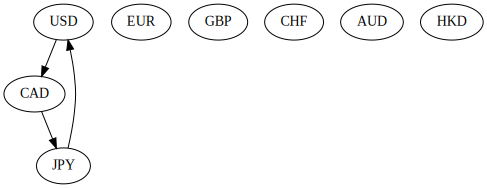

In [ ]:
m = arbitrage(3, df, 'USD')
graph(m)